In [1]:
# ===============================
# ERA5 – Reggio Calabria UHI analysis
# ===============================

import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = True


In [2]:
# --- CONFIG ---

# Folder containing files like:
#  2018_2m_temperature_daily_maximum.nc
#  2019_2m_temperature_daily_maximum.nc
#  ...
era5_data_folder = Path(r"C:\Users\naso_\Documents\PoliMi\GenHack5\derived-era5-land-daily-statistics") 

# Reggio Calabria city centre (approximate, only for distance masks)
city_lat = 38.1105
city_lon = 15.6613

print("ERA5 folder:", era5_data_folder)
print("Reggio Calabria centre:", city_lat, city_lon)

# Quick check: list a few files
for f in list(era5_data_folder.glob("*.nc"))[:10]:
    print(" -", f.name)


ERA5 folder: C:\Users\naso_\Documents\PoliMi\GenHack5\derived-era5-land-daily-statistics
Reggio Calabria centre: 38.1105 15.6613
 - 2020_10m_u_component_of_wind_daily_mean.nc
 - 2020_10m_v_component_of_wind_daily_mean.nc
 - 2020_2m_temperature_daily_maximum.nc
 - 2020_total_precipitation_daily_mean.nc
 - 2021_10m_u_component_of_wind_daily_mean.nc
 - 2021_10m_v_component_of_wind_daily_mean.nc
 - 2021_2m_temperature_daily_maximum.nc
 - 2021_total_precipitation_daily_mean.nc
 - 2022_10m_u_component_of_wind_daily_mean.nc
 - 2022_10m_v_component_of_wind_daily_mean.nc


In [6]:
t2m_files = sorted(era5_data_folder.glob("*_2m_temperature_daily_maximum.nc"))

print(f"Found {len(t2m_files)} files:")
for f in t2m_files:
    print(" -", f.name)

ds_t2m = xr.open_mfdataset(
    t2m_files,
    combine="by_coords",
    engine="netcdf4",   # <--- now valid
    parallel=False      # can set True later if you install dask
)

ds_t2m

Found 6 files:
 - 2020_2m_temperature_daily_maximum.nc
 - 2021_2m_temperature_daily_maximum.nc
 - 2022_2m_temperature_daily_maximum.nc
 - 2023_2m_temperature_daily_maximum.nc
 - 2024_2m_temperature_daily_maximum.nc
 - 2025_2m_temperature_daily_maximum.nc


<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
var_name = "t2m"
ds_t2m["t2m_c"] = ds_t2m[var_name] - 273.15
ds_t2m["t2m_c"].attrs["units"] = "°C"
ds_t2m = ds_t2m[["t2m_c"]]


In [19]:
# --- 2. Subset ERA5 to Reggio Calabria area using a bounding box ---

lat_half_span = 0.4   # degrees N/S (~44 km)
lon_half_span = 0.4   # degrees E/W

lat_min = city_lat - lat_half_span
lat_max = city_lat + lat_half_span
lon_min = city_lon - lon_half_span
lon_max = city_lon + lon_half_span

print("AOI bbox:")
print(f"  lat: {lat_min:.3f} to {lat_max:.3f}")
print(f"  lon: {lon_min:.3f} to {lon_max:.3f}")

# ERA5 latitudes are usually decreasing, so use slice(lat_max, lat_min)
ds_aoi = ds_t2m.sel(
    longitude=slice(lon_min, lon_max),
    latitude=slice(lat_max, lat_min)
)

ds_aoi


AOI bbox:
  lat: 37.711 to 38.511
  lon: 15.261 to 16.061


<xarray.Dataset> Size: 554kB
Dimensions:    (time: 2098, latitude: 8, longitude: 8)
Coordinates:
  * time       (time) datetime64[ns] 17kB 2020-01-01 2020-01-02 ... 2025-09-28
  * latitude   (latitude) float64 64B 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8
  * longitude  (longitude) float64 64B 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.0
    number     int64 8B 0
Data variables:
    t2m_c      (time, latitude, longitude) float32 537kB dask.array<chunksize=(23, 8, 8), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [20]:
# --- 3. Summer subset & basic cleaning ---

summer_months = [5, 6, 7, 8, 9]  # May–September
ds_summer = ds_aoi.sel(time=ds_aoi.time.dt.month.isin(summer_months))

print("Summer period: from", str(ds_summer.time.values[0])[:10],
      "to", str(ds_summer.time.values[-1])[:10])
print("Number of summer days:", ds_summer.dims["time"])

# Remove unrealistic extremes (safety)
t = ds_summer["t2m_c"]
ds_summer["t2m_c"] = t.where((t > -40) & (t < 60))

ds_summer


Summer period: from 2020-05-01 to 2025-09-28
Number of summer days: 916


C:\Users\naso_\AppData\Local\Temp\ipykernel_1708\2726481179.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Number of summer days:", ds_summer.dims["time"])


<xarray.Dataset> Size: 242kB
Dimensions:    (time: 916, latitude: 8, longitude: 8)
Coordinates:
  * time       (time) datetime64[ns] 7kB 2020-05-01 2020-05-02 ... 2025-09-28
  * latitude   (latitude) float64 64B 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8
  * longitude  (longitude) float64 64B 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.0
    number     int64 8B 0
Data variables:
    t2m_c      (time, latitude, longitude) float32 234kB dask.array<chunksize=(21, 8, 8), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

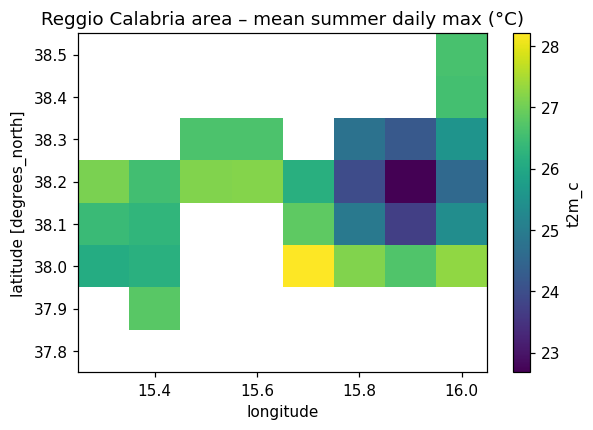

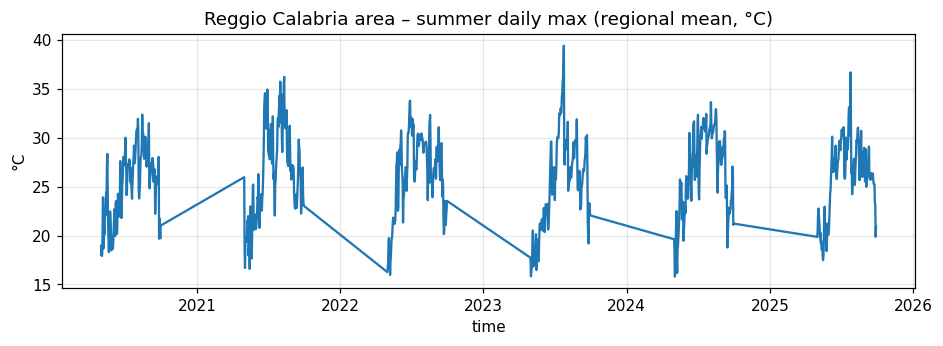

,number,t2m_c_mean
year,,
2020,0,25.156075
2021,0,26.452553
2022,0,26.408497
2023,0,25.310917
2024,0,26.608431


,number,t2m_c_max
year,,
2020,0,35.176239
2021,0,39.135590
2022,0,36.665985
2023,0,41.560760
2024,0,36.606781


In [21]:
# --- 4. Summer climatology ---

# Mean summer map (all years)
mean_summer_map = ds_summer["t2m_c"].mean("time")

plt.figure(figsize=(6, 4))
mean_summer_map.plot()
plt.title("Reggio Calabria area – mean summer daily max (°C)")
plt.show()

# Regional mean daily series
summer_mean_ts = ds_summer["t2m_c"].mean(dim=["latitude", "longitude"])

plt.figure(figsize=(10, 3))
summer_mean_ts.plot()
plt.title("Reggio Calabria area – summer daily max (regional mean, °C)")
plt.ylabel("°C")
plt.grid(True, alpha=0.3)
plt.show()

# Yearly mean / max summer temperature (regional)
summer_by_year = ds_summer["t2m_c"].groupby("time.year")
summer_mean_by_year = summer_by_year.mean(dim=["time", "latitude", "longitude"])
summer_max_by_year  = summer_by_year.max(dim=["time", "latitude", "longitude"])

display(summer_mean_by_year.to_dataframe("t2m_c_mean").head())
display(summer_max_by_year.to_dataframe("t2m_c_max").head())


Urban cells: 2
Rural cells: 42


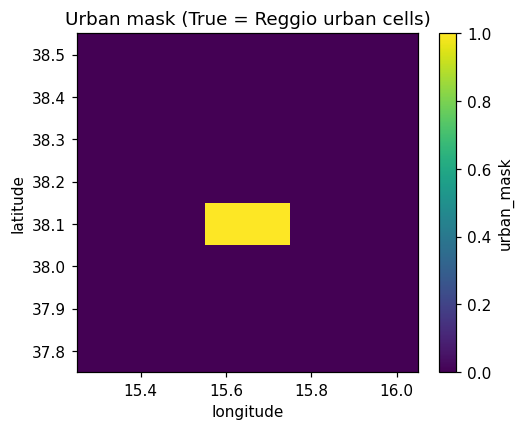

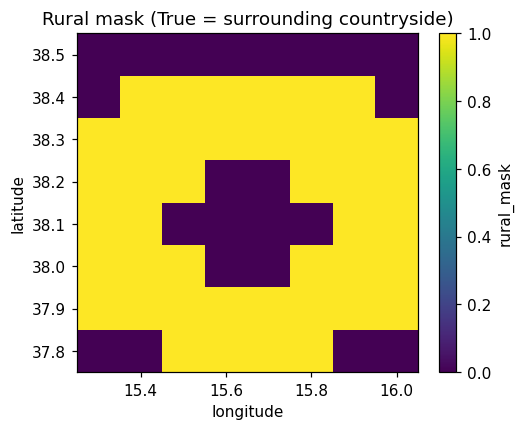

In [27]:
# --- 5. Build urban / rural masks around Reggio using distance from city centre ---

lat_vals = ds_aoi["latitude"].values
lon_vals = ds_aoi["longitude"].values

lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)

# Approximate distance in km
dlat = lat_mesh - city_lat
dlon = lon_mesh - city_lon

km_per_deg_lat = 111.0
km_per_deg_lon = 111.0 * np.cos(np.deg2rad(city_lat))

dist_km = np.sqrt(
    (dlat * km_per_deg_lat) ** 2 +
    (dlon * km_per_deg_lon) ** 2
)

# Radii (you can tune)
urban_radius_km = 8
rural_inner_km = 15
rural_outer_km = 40

urban_mask_2d = dist_km <= urban_radius_km
rural_mask_2d = (dist_km >= rural_inner_km) & (dist_km <= rural_outer_km)

print("Urban cells:", int(urban_mask_2d.sum()))
print("Rural cells:", int(rural_mask_2d.sum()))

urban_mask = xr.DataArray(
    urban_mask_2d,
    coords={"latitude": lat_vals, "longitude": lon_vals},
    dims=("latitude", "longitude"),
    name="urban_mask"
)

rural_mask = xr.DataArray(
    rural_mask_2d,
    coords={"latitude": lat_vals, "longitude": lon_vals},
    dims=("latitude", "longitude"),
    name="rural_mask"
)

plt.figure(figsize=(5, 4))
urban_mask.plot()
plt.title("Urban mask (True = Reggio urban cells)")
plt.show()

plt.figure(figsize=(5, 4))
rural_mask.plot()
plt.title("Rural mask (True = surrounding countryside)")
plt.show()


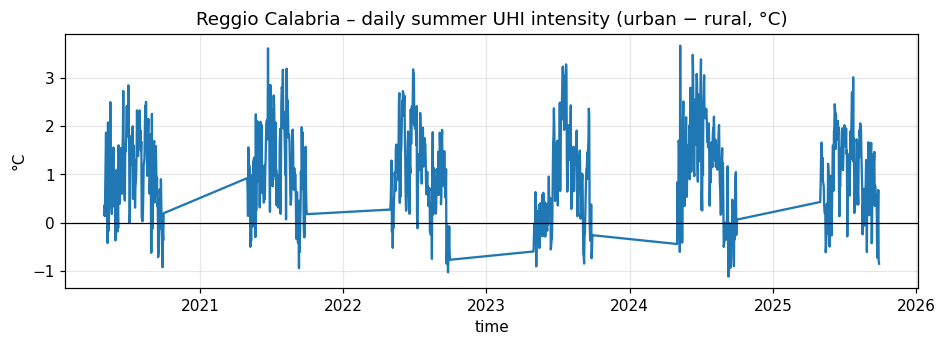

In [23]:
# --- 6. UHI intensity (urban - rural) for summer ---

t_summer = ds_summer["t2m_c"]

urban_mean_ts = t_summer.where(urban_mask).mean(dim=["latitude", "longitude"])
rural_mean_ts = t_summer.where(rural_mask).mean(dim=["latitude", "longitude"])

uhi_ts = (urban_mean_ts - rural_mean_ts).rename("UHI_intensity")

plt.figure(figsize=(10, 3))
uhi_ts.plot()
plt.axhline(0, color="k", linewidth=0.8)
plt.title("Reggio Calabria – daily summer UHI intensity (urban − rural, °C)")
plt.ylabel("°C")
plt.grid(True, alpha=0.3)
plt.show()


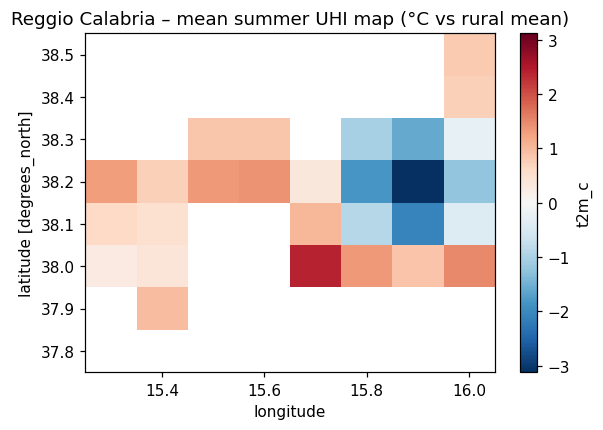

In [24]:
# --- 6.1 Mean summer UHI map (per grid cell) ---

rural_mean_per_day = t_summer.where(rural_mask).mean(dim=["latitude", "longitude"])
uhi_map_daily = t_summer - rural_mean_per_day
uhi_map_mean = uhi_map_daily.mean("time")

plt.figure(figsize=(6, 4))
uhi_map_mean.plot()
plt.title("Reggio Calabria – mean summer UHI map (°C vs rural mean)")
plt.show()


In [ ]:
# --- 7. Save processed ERA5 outputs for Reggio Calabria ---

out_dir = era5_data_folder / "processed_reggio"
out_dir.mkdir(exist_ok=True)

clim_ds = xr.Dataset({
    "t2m_summer_mean": mean_summer_map,
    "uhi_summer_mean": uhi_map_mean,
    "urban_mask": urban_mask,
    "rural_mask": rural_mask
})
clim_ds.to_netcdf(out_dir / "era5_reggio_summer_climatology_uhi.nc")

ts_df = pd.DataFrame({
    "time": uhi_ts["time"].values,
    "urban_mean": urban_mean_ts.values,
    "rural_mean": rural_mean_ts.values,
    "uhi_intensity": uhi_ts.values
}).set_index("time")

ts_df.to_csv(out_dir / "era5_reggio_uhi_timeseries.csv")
ts_df.head()


In [29]:
# === Load other ERA5 variables for correlation analysis ===

def load_variable(pattern):
    files = sorted(era5_data_folder.glob(pattern))
    print(f"Loading {pattern}: {len(files)} files")
    datasets = [xr.open_dataset(f, engine="netcdf4") for f in files]
    ds = xr.concat(datasets, dim="valid_time")
    return ds.rename({"valid_time": "time"})

ds_u10 = load_variable("*_10m_u_component_of_wind_daily_mean.nc")
ds_v10 = load_variable("*_10m_v_component_of_wind_daily_mean.nc")
ds_tp  = load_variable("*_total_precipitation_daily_mean.nc")

# Convert temperature dataset (you already have ds_t2m)
ds_t2m


Loading *_10m_u_component_of_wind_daily_mean.nc: 6 files
Loading *_10m_v_component_of_wind_daily_mean.nc: 6 files
Loading *_total_precipitation_daily_mean.nc: 6 files


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * time       (time) datetime64[ns] 17kB 2020-01-01 2020-01-02 ... 2025-09-28
  * latitude   (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude  (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number     int64 8B 0
Data variables:
    t2m_c      (time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [32]:
# Make sure all datasets share exactly the same time axis
ds_u10, ds_v10, ds_tp, ds_t2m = xr.align(
    ds_u10, ds_v10, ds_tp, ds_t2m, join="inner"
)


In [33]:
# === Subset all variables to the same Reggio AOI ===
ds_u10_aoi = ds_u10.sel(longitude=slice(lon_min, lon_max),
                        latitude=slice(lat_max, lat_min))
ds_v10_aoi = ds_v10.sel(longitude=slice(lon_min, lon_max),
                        latitude=slice(lat_max, lat_min))
ds_tp_aoi  = ds_tp.sel(longitude=slice(lon_min, lon_max),
                       latitude=slice(lat_max, lat_min))
ds_t2m_aoi = ds_t2m.sel(longitude=slice(lon_min, lon_max),
                        latitude=slice(lat_max, lat_min))

# === Daily mean across AOI (spatial average) ===
u10_ts = ds_u10_aoi["u10"].mean(dim=["latitude", "longitude"])
v10_ts = ds_v10_aoi["v10"].mean(dim=["latitude", "longitude"])
tp_ts  = ds_tp_aoi["tp"].mean(dim=["latitude", "longitude"])
t2m_ts = ds_t2m_aoi["t2m_c"].mean(dim=["latitude", "longitude"])


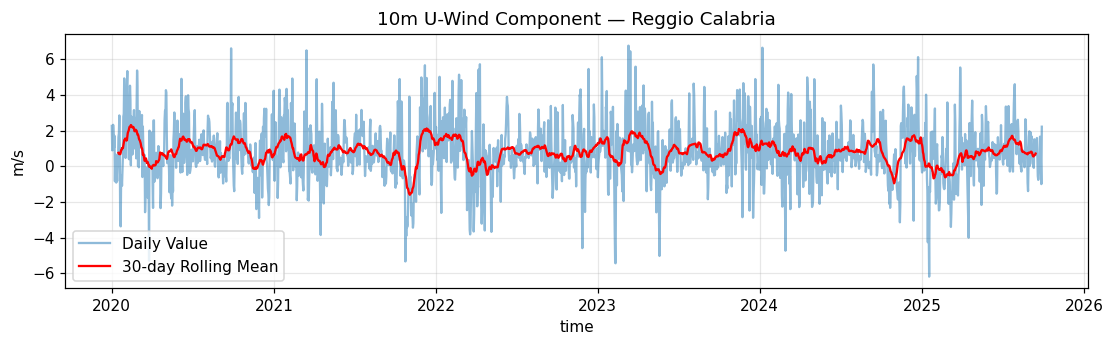

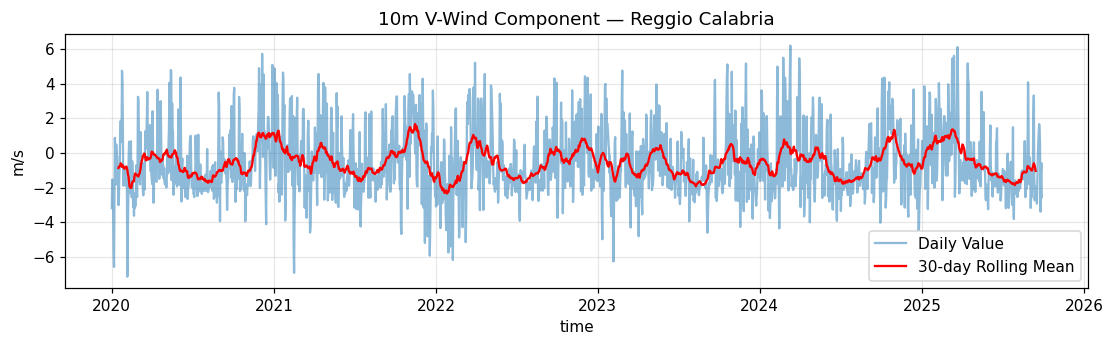

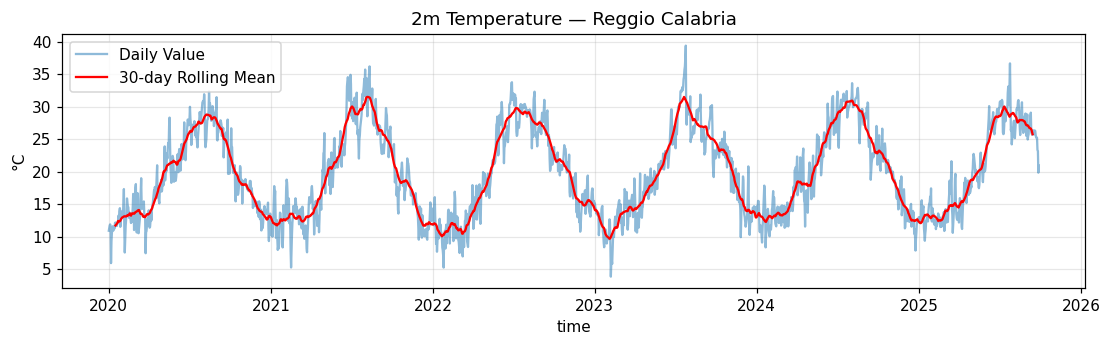

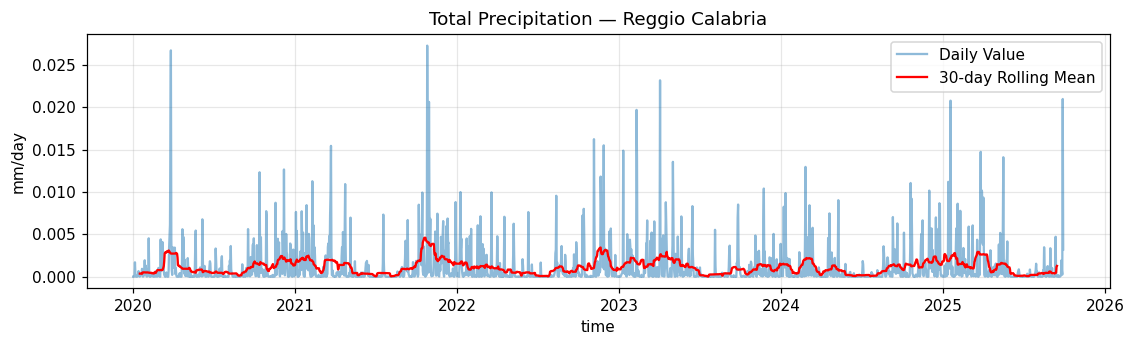

In [35]:
import matplotlib.pyplot as plt

def plot_ts(series, title, ylabel):
    plt.figure(figsize=(12,3))
    series.plot(label="Daily Value", alpha=0.5)

    # xarray rolling: specify the dimension name (here it's "time")
    rolling_mean = series.rolling(time=30, center=True).mean()
    rolling_mean.plot(label="30-day Rolling Mean", color="red")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_ts(u10_ts, "10m U-Wind Component — Reggio Calabria", "m/s")
plot_ts(v10_ts, "10m V-Wind Component — Reggio Calabria", "m/s")
plot_ts(t2m_ts, "2m Temperature — Reggio Calabria", "°C")
plot_ts(tp_ts,  "Total Precipitation — Reggio Calabria", "mm/day")


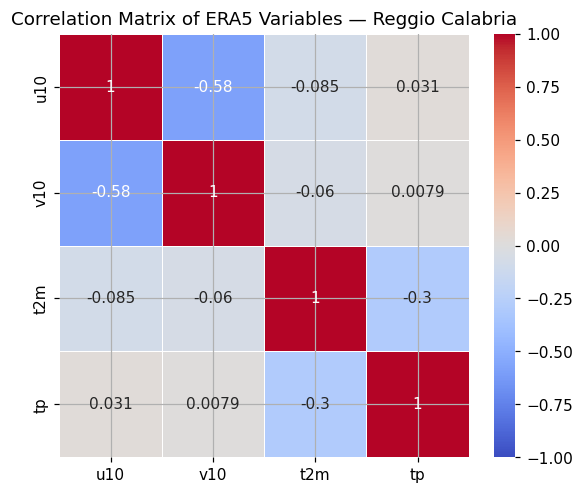

In [37]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({
    "u10": u10_ts.values,
    "v10": v10_ts.values,
    "t2m": t2m_ts.values,
    "tp": tp_ts.values
}, index=u10_ts.time.to_pandas())

corr_matrix = df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix of ERA5 Variables — Reggio Calabria")
plt.show()


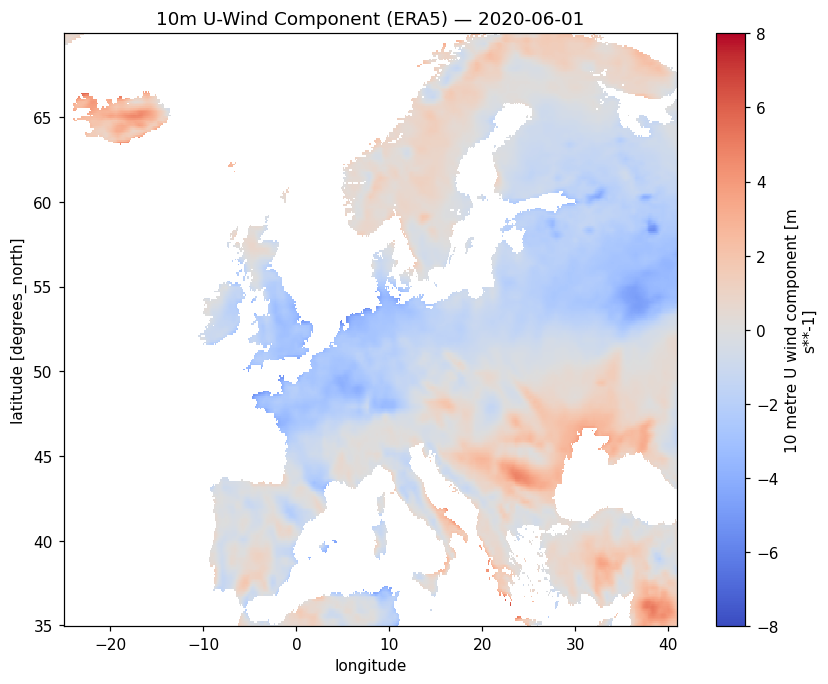

In [38]:
# === Europe-wide U-wind map ===
example_day = "2020-06-01"

ds_u10_day = ds_u10.sel(time=example_day)

plt.figure(figsize=(9,7))
ds_u10_day["u10"].plot(cmap="coolwarm", vmin=-8, vmax=8)
plt.title(f"10m U-Wind Component (ERA5) — {example_day}")
plt.show()


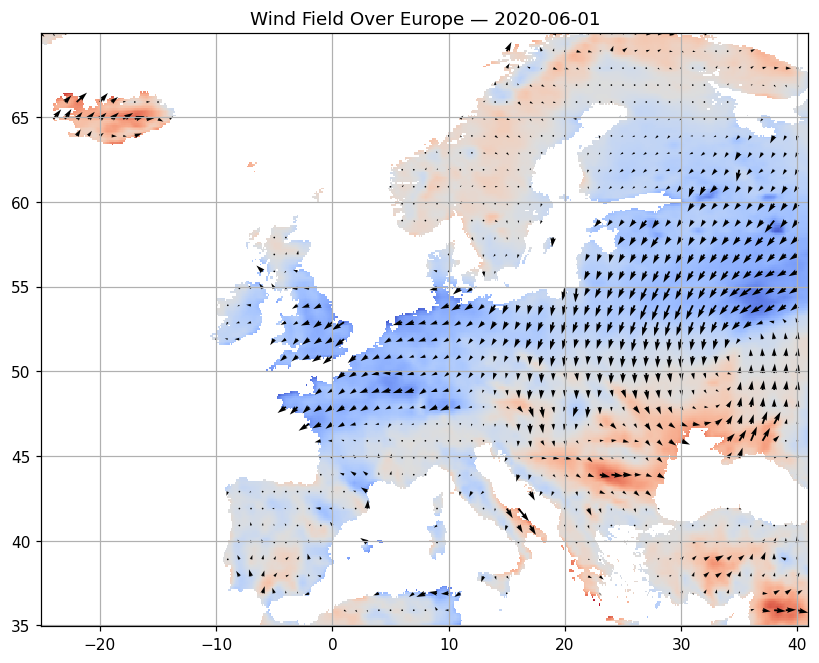

In [39]:
# Optional: add quiver arrows (downsampled)
step = 10
plt.figure(figsize=(9,7))
plt.pcolormesh(ds_u10_day.longitude, ds_u10_day.latitude, ds_u10_day["u10"], cmap="coolwarm")

plt.quiver(
    ds_u10_day.longitude[::step],
    ds_u10_day.latitude[::step],
    ds_u10_day["u10"][::step, ::step],
    ds_v10.sel(time=example_day)["v10"][::step, ::step],
    scale=300
)

plt.title(f"Wind Field Over Europe — {example_day}")
plt.show()


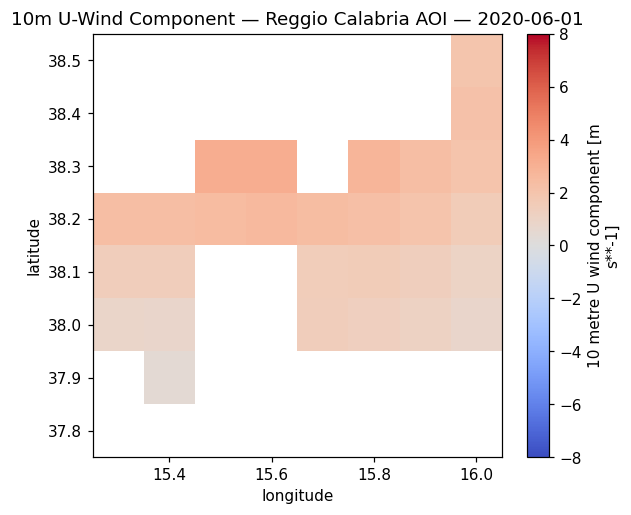

In [41]:
# --- U-wind map over Reggio Calabria AOI for one day ---

example_day = "2020-06-01"

# Subset to AOI first
ds_u10_reggio = ds_u10.sel(
    longitude=slice(lon_min, lon_max),
    latitude=slice(lat_max, lat_min)
)

ds_u10_reggio_day = ds_u10_reggio.sel(time=example_day)

plt.figure(figsize=(6,5))
ds_u10_reggio_day["u10"].plot(
    cmap="coolwarm", vmin=-8, vmax=8
)
plt.title(f"10m U-Wind Component — Reggio Calabria AOI — {example_day}")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()


In [43]:
# === UHI maps for all days: T_local - mean(T_rural) ===

t_all = ds_aoi["t2m_c"]  # (time, latitude, longitude)

# Daily rural mean temperature
rural_mean_all = t_all.where(rural_mask).mean(dim=["latitude", "longitude"])

# UHI map per day (broadcast over latitude/longitude)
uhi_map_all = t_all - rural_mean_all
uhi_map_all.name = "UHI"   # just for nice labels
uhi_map_all.attrs["units"] = "°C"

uhi_map_all


<xarray.DataArray 'UHI' (time: 2098, latitude: 8, longitude: 8)> Size: 537kB
dask.array<sub, shape=(2098, 8, 8), dtype=float32, chunksize=(23, 8, 8), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 17kB 2020-01-01 2020-01-02 ... 2025-09-28
  * latitude   (latitude) float64 64B 38.5 38.4 38.3 38.2 38.1 38.0 37.9 37.8
  * longitude  (longitude) float64 64B 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.0
    number     int64 8B 0
Attributes:
    units:    °C

Years available: [2020 2021 2022 2023 2024 2025]


C:\Users\naso_\AppData\Local\Temp\ipykernel_1708\1019540341.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


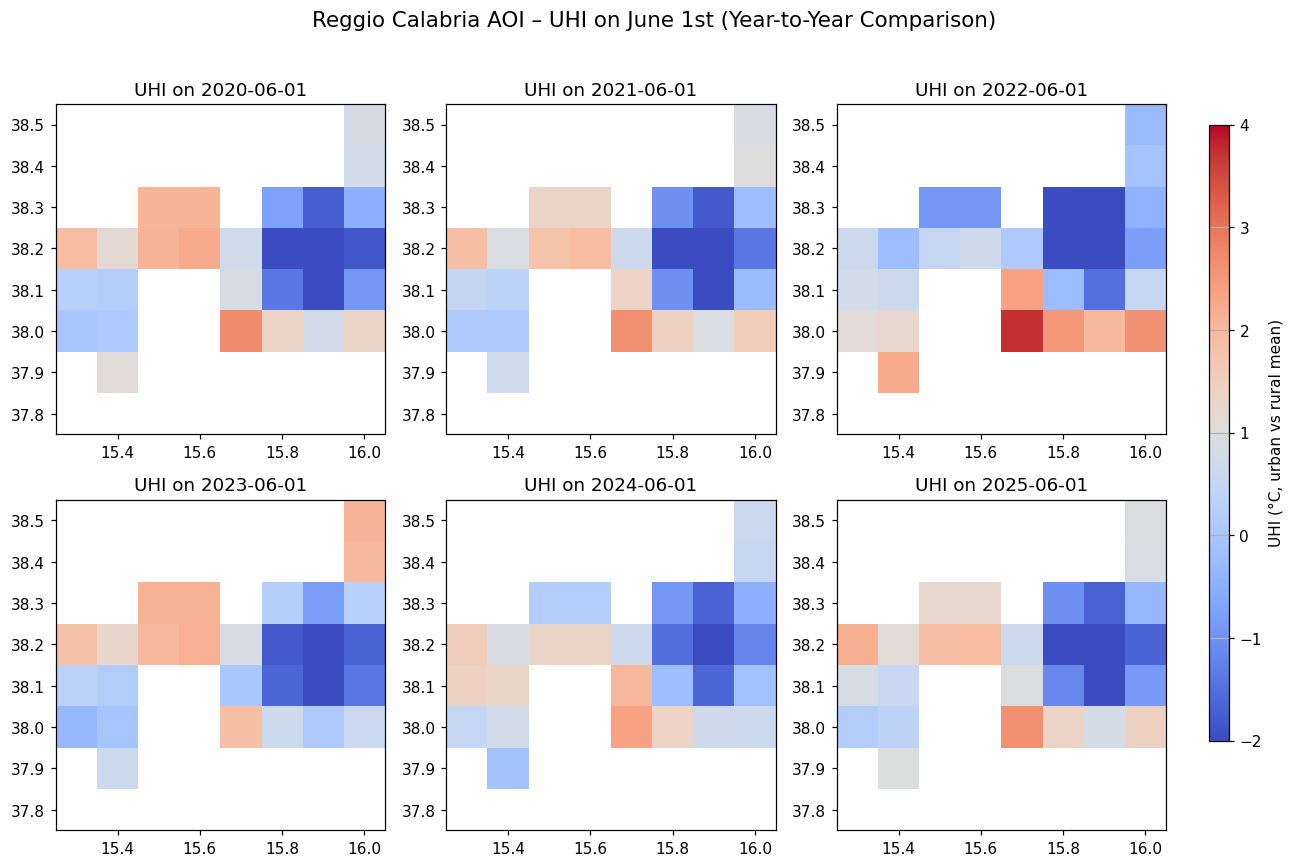

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# AOI is already ds_aoi, and uhi_map_all is defined on that AOI
# Years present in the dataset
years = np.unique(uhi_map_all.time.dt.year.values)
print("Years available:", years)

# Choose the date within each year (e.g. June 1st)
month = 6
day   = 1

n_years = len(years)
ncols = 3
nrows = int(np.ceil(n_years / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), squeeze=False)

for ax, year in zip(axes.ravel(), years):
    target_date = f"{year}-{month:02d}-{day:02d}"
    
    # UHI map for that date (nearest day in case of missing)
    da = uhi_map_all.sel(time=target_date, method="nearest")
    
    im = da.plot(
        ax=ax,
        cmap="coolwarm",
        vmin=-2, vmax=4,   # adjust range if needed
        add_colorbar=False
    )
    ax.set_title(f"UHI on {target_date}")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Remove empty subplots if any
for ax in axes.ravel()[n_years:]:
    ax.axis("off")

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="UHI (°C, urban vs rural mean)")

plt.suptitle(
    "Reggio Calabria AOI – UHI on June 1st (Year-to-Year Comparison)",
    fontsize=14, y=0.98
)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()


C:\Users\naso_\AppData\Local\Temp\ipykernel_1708\806765636.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


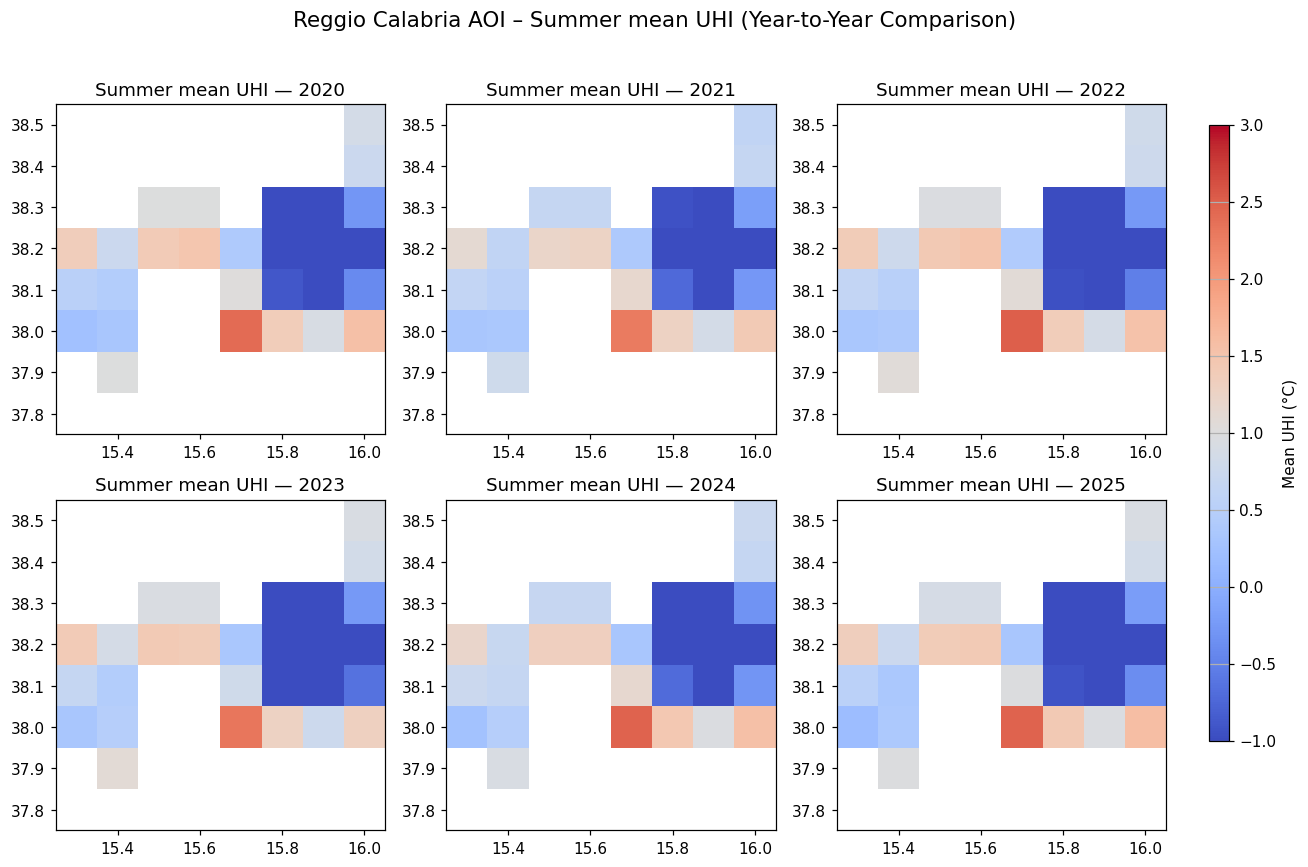

In [46]:
summer_months = [5, 6, 7, 8, 9]
uhi_summer = uhi_map_all.sel(time=uhi_map_all.time.dt.month.isin(summer_months))

years = np.unique(uhi_summer.time.dt.year.values)
n_years = len(years)
ncols = 3
nrows = int(np.ceil(n_years / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), squeeze=False)

for ax, year in zip(axes.ravel(), years):
    da = uhi_summer.sel(time=uhi_summer.time.dt.year == year).mean("time")
    
    im = da.plot(
        ax=ax,
        cmap="coolwarm",
        vmin=-1, vmax=3,   # often UHI is smaller when averaged
        add_colorbar=False
    )
    ax.set_title(f"Summer mean UHI — {year}")
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in axes.ravel()[n_years:]:
    ax.axis("off")

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Mean UHI (°C)")

plt.suptitle("Reggio Calabria AOI – Summer mean UHI (Year-to-Year Comparison)",
             fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()
